
## Defining Instructions
Examples of instructions are listed below in the table.

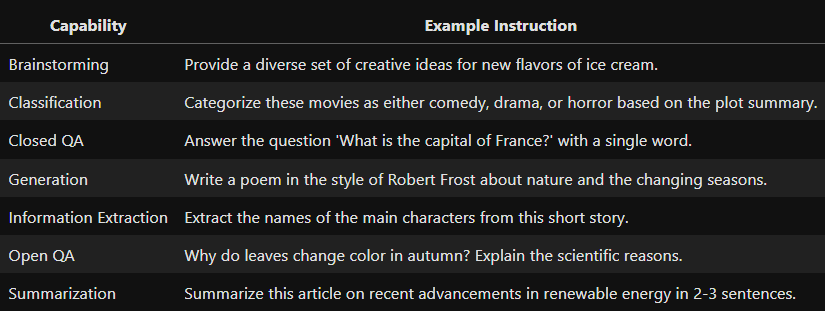

We want to fine-tune the model to follow instructions, this this notebook uses the `Alpaca` form to format dataset.

```
### Instruction:
Use the Input below to create an instruction, which could have been used to generate the input using an LLM.

### Input:
Dear [boss name],

I'm writing to request next week, August 1st through August 4th,
off as paid time off.......

### Response:
Write an email to my boss that I need next week 08/01 - 08/04 off.
```

In [1]:
# installing dependencies
!pip -q install "transformers==4.34.0"
!pip -q install "datasets" "peft" "accelerate" "bitsandbytes" "trl" "safetensors"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.2/417.2 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Load  🤗 Datasets

To load the databricks/databricks-dolly-15k dataset, we use the load_dataset() method from the 🤗 Datasets library. A `formatting_function()` is defined to format the dataset into the alpaca format described above.

In [1]:
from datasets import load_dataset
from random import randrange

# Load dataset from the hub
dataset = load_dataset("databricks/databricks-dolly-15k", split="train")

print(f"dataset size: {len(dataset)}")
print(dataset[randrange(len(dataset))])

dataset size: 15011
{'instruction': 'Discuss ways in which brands in your industry (or industry of your choice) could benefit from the web\'s gift to measurement: "the ability to fail faster. At a low cost."\u202fProvide at least one example supporting your ideas', 'context': '', 'response': 'Kia Carnival is a new MPV (multi-purpose vehicle) 7-seater minivan directly competing with the industry leaders like Honda Odyssey, Toyota Sienna, and Chrysler Pacifica. Kia Carnival faces an uphill battle against the industry leader to gain market share. Kia Carnival can perform a small, low-cost experiment to measure consumer outcomes, customer value, and attribution to increase sales and optimize its spending on digital marketing. \u202f \n\nThe minivan buyers typically visit the Kia Carnival website, engage in a vehicle build configurator, and perform inventory checks to get an overview of the vehicle and price. Post this, the buyers will check YouTube videos and Twitter reviews and visit a Ki

In [2]:
def format_instruction(sample):
  text =  f"""### Instruction:
  {sample['instruction']}

  ### Input:
  {sample['context']}

  ### Response:
  {sample['response']}"""

  return { "text" : text}

from random import randrange
print(format_instruction(dataset[randrange(len(dataset))]))

{'text': "### Instruction:\n  When was siri for the iphone created?\n\n  ### Input:\n  \n\n  ### Response:\n  Siri was first created back in 2011 by Apple.  It's original use was for the Iphone as a virtual voice assistant that used artificial intelligence.  The voice of siri is done by Susan Bennett.  She is a voice over artist, and over the years siri has other voices that can be used too.  Siri can open applications on the iphone for you, give weather updates, set alarms and reminders, take notes for you, and automate most tasks that you can do on your iphone yourself.  Amazon Alexa was create two years after Siri because of the rise in popularity of virtual voice assistants."}


## Load the model.

The model used will be `NousResearch/Nous-Hermes-2-Mistral-7B-DPOl` which is a non-gated version of the mistral model. Flash Attention will enabled on A100 for now we'll comment that out.

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# use_flash_attention = False

model_id = "crumb/nano-mistral"  # non-gated

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    use_cache=False,
    # use_flash_attention_2=use_flash_attention,
    device_map="auto",
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/340M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

## LoRA Configs

The `SFTTrainer`  supports a native integration with `peft`, which makes it super easy to efficiently instruction tune LLMs. We only need to create our `LoRAConfig` and provide it to the trainer.

In [4]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

# LoRA config based on QLoRA paper
peft_config = LoraConfig(
        lora_alpha=16,
        lora_dropout=0.1,
        r=64,
        # target_modules="all-linear", # This for checkpoint pretrained models directly like meta llama.
        bias="none",
        task_type="CAUSAL_LM",
)
# prepare model for training
model = prepare_model_for_kbit_training(model)
# Add the adaptor to model
model = get_peft_model(model, peft_config)

model.print_trainable_parameters()

trainable params: 1,597,440 || all params: 171,679,488 || trainable%: 0.9305


Before we can start our training we need to define the hyperparameters (`TrainingArguments`) we want to use.



In [5]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="llama-7-int4-dolly",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    optim="adamw_bnb_8bit",
    logging_steps=10,
    save_strategy="epoch",
    learning_rate=2e-4,
    bf16=False,
    fp16=True,
    tf32=False,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="cosine",
    disable_tqdm=False,  # disable tqdm since with packing values are in correct
)

In [6]:
dat = dataset.map(format_instruction, remove_columns=['instruction', 'context', 'response', 'category'])
dat

Dataset({
    features: ['text'],
    num_rows: 15011
})

In [7]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    train_dataset=dat,
    peft_config=peft_config,
    dataset_text_field='text',
    tokenizer=tokenizer,
    packing=False,
    formatting_func=format_instruction,
    args=args,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:289: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/15011 [00:00<?, ? examples/s]

In [ ]:
# train
trainer.train() # there will not be a progress bar since tqdm is disabled

# save model
trainer.save_model()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
10,3.014700
20,2.982000
30,3.010400
40,2.863800
50,2.925200
60,2.784500
70,2.680400
80,2.701800
90,2.566000
100,2.600200
